# using deep learning to classify x-ray image


1. [Import Libraries](#import-libraries)
2. [EDA](#EDA)
3. [create dataset](#create-dataset)
4. [images preprocess and use class weight to solve imbalance problem](#images-preprocess)
5. [Training the Model](#training-the-model)
6. [Plotting Training and Validation Accuracy and Loss](#plotting-training-and-validation-accuracy-and-loss)
7. [Compute Accuracy](#compute-accuracy)
8. [Loading the Model and Making Predictions](#loading-the-model-and-making-predictions)


In [150]:
#import-libraries

import matplotlib.pyplot as plt
import numpy as np
import os
import glob as gb
import cv2
import shutil
import pickle
import seaborn as sns
from keras.applications.vgg16 import VGG16

from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Conv2D, MaxPooling2D, AvgPool2D, Input, Dropout, Flatten, BatchNormalization
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, recall_score, f1_score, accuracy_score


#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
BASE_DIR_train ="/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
BASE_DIR_test="/kaggle/input/chest-xray-pneumonia/chest_xray/test/"


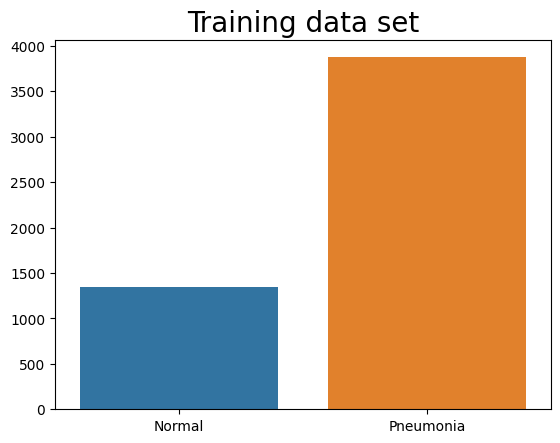

In [4]:
#EDA
train_img = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(BASE_DIR_train+'NORMAL', filename) 
                     for filename in os.listdir(BASE_DIR_train+'NORMAL')])], 
     'Pneumonia': [len([os.path.join(BASE_DIR_train+'PNEUMONIA', filename) 
                        for filename in os.listdir(BASE_DIR_train+'PNEUMONIA')])]})


sns.barplot(data=train_img).set_title('Training data set', fontsize=20)
plt.show()

as we can see here there is aproblem in dataset which is implanced datatset
to solve this problem we have many solution:
- class weight
- SMOTE
- over sample
- down sample


In [5]:
#create-dataset
#first creat function that take the path of the imags and return data frame contain images
#and label then encode label using labelencoder
def img_path(path):
    normal_imgs = os.listdir(os.path.join(path,"NORMAL"))
    pneumonia_imgs = os.listdir(os.path.join(path,"PNEUMONIA"))
    normal_paths = [os.path.join(path,"NORMAL",filename) for filename in normal_imgs]
    pneumonia_paths = [os.path.join(path,"PNEUMONIA",filename) for filename in  pneumonia_imgs]
    normal_labels = ["NORMAL" for i in range( len(normal_paths) )]
    pneumonia_labels = ["PNEUMONIA" for i in range(len(pneumonia_paths))]
    df = pd.DataFrame({
    "images":[*normal_paths , *pneumonia_paths],
    "target":[*normal_labels,*pneumonia_labels]})
    labelencoder = LabelEncoder()
    df['target_encoded'] = labelencoder.fit_transform(df['target'])
    return df
    

In [6]:
df=img_path("/kaggle/input/chest-xray-pneumonia/chest_xray/train/")
df.shape

(5216, 3)

In [7]:
df.head(5)

,images,target,target_encoded
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,0
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,0
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,0
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,0
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL,0


In [8]:
#i will depend on the train image for both train and validation i will split images to train and validation
train, validation = train_test_split(df, test_size=0.2, random_state=42,stratify=df['target_encoded'])


In [23]:
#images-preprocess
#create preprocess function and add class weight to solve imbalanced class problem
def img_preprocess(df):
    new_size = 224    
    X = []
    y = []
    
    for idx, row in df.iterrows():
        file = row['images']
        image_class = row['target_encoded']
        original_image = cv2.imread(file)
        
        if original_image is not None:
            image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            resized_image = cv2.resize(image, (new_size, new_size))
            X.append(resized_image)
            y.append(image_class)
        else:
            print(f"Warning: Image {file} not found or unable to read")
    
    X = np.array(X)
    y = np.array(y)
    
    # Normalize image 
    X = X / 255.0
    # use class weights to avoid imbanced problem
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    class_weights_dict = dict(enumerate(class_weights))

    print("Class Weights: ", class_weights_dict)

    # Convert labels to categorical format
    y = to_categorical(y, num_classes=2)
    
    return X, y,class_weights_dict


In [24]:
X_train, y_train,class_weights_dict= img_preprocess(train)


Class Weights:  {0: 1.9440820130475303, 1: 0.6731203614069055}


In [25]:
X_val, y_val,class_weights_dict= img_preprocess(validation)


Class Weights:  {0: 1.9477611940298507, 1: 0.6726804123711341}


In [26]:
test=img_path("/kaggle/input/chest-xray-pneumonia/chest_xray/test/")
X_test, y_test,class_weights_dict= img_preprocess(test)


Class Weights:  {0: 1.3333333333333333, 1: 0.8}


In [51]:
#training-the-model
#try basic cnn mosel
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(2, activation='softmax')
])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │       788,546 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,442 (3.01 MB)

 Trainable params: 789,442 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
earlystop = EarlyStopping("val_accuracy", patience=30, verbose=1, restore_best_weights=True,)


In [54]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[earlystop],
    class_weight=class_weights_dict
)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9335 - loss: 0.3548 - val_accuracy: 0.9540 - val_loss: 0.1444
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9777 - loss: 0.0677 - val_accuracy: 0.9569 - val_loss: 0.1122
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9871 - loss: 0.0387 - val_accuracy: 0.9684 - val_loss: 0.1039
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9920 - loss: 0.0214 - val_accuracy: 0.9550 - val_loss: 0.1339
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9929 - loss: 0.0195 - val_accuracy: 0.9665 - val_loss: 0.0947
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9693 - val_loss: 0.1017
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9713 - val_loss: 0.0996
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accu

In [55]:
#compute-accuracy
def model_accuracy():
    y_test_pred = model.predict(X_test)
    y_pred = np.argmax(y_test_pred, axis=1)
    y_true=np.argmax(y_test, axis=1) 
    cm = confusion_matrix(y_true, y_pred)
    print("confusion matrix:",cm)
    fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
    plt.show()
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

In [56]:
model.evaluate(X_train,y_train)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9741 - loss: 0.0741


[0.07216078042984009, 0.9743528366088867]

In [57]:
model.evaluate(X_val,y_val)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9547 - loss: 0.1362


[0.14444972574710846, 0.954023003578186]

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

W0000 00:00:1722461368.633821     206 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
confusion matrix: [[108 126]
 [ 12 378]]


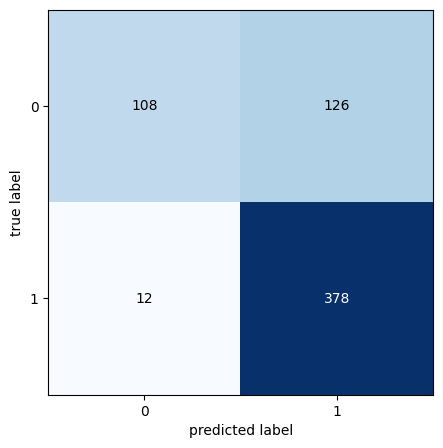

              precision    recall  f1-score   support

      Normal       0.90      0.46      0.61       234
   Pneumonia       0.75      0.97      0.85       390

    accuracy                           0.78       624
   macro avg       0.82      0.72      0.73       624
weighted avg       0.81      0.78      0.76       624

Accuracy: 0.7788461538461539
Recall: 0.7153846153846154
F1 Score: 0.7279035377090206


In [58]:
model_accuracy()

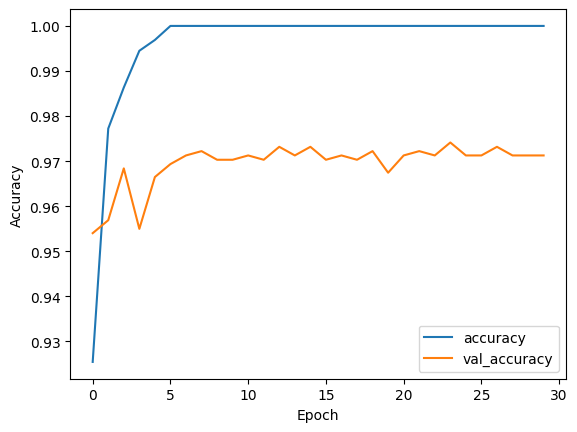

In [59]:
#plotting-training-and-validation-accuracy-and-loss
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [60]:
#lets make some fine tuning by adding dropout layer
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │       788,546 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,442 (3.01 MB)

 Trainable params: 789,442 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
earlystop = EarlyStopping("val_accuracy", patience=30, verbose=1, restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[earlystop],
    class_weight=class_weights_dict
)

Epoch 1/50
  5/131 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4720 - loss: 14.9204

W0000 00:00:1722461468.585383     205 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7609 - loss: 3.6140

W0000 00:00:1722461475.258943     204 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.7617 - loss: 3.5953 - val_accuracy: 0.9531 - val_loss: 0.1218
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9693 - loss: 0.0843 - val_accuracy: 0.9626 - val_loss: 0.0923
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9780 - loss: 0.0622 - val_accuracy: 0.9684 - val_loss: 0.0807
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9900 - loss: 0.0320 - val_accuracy: 0.9684 - val_loss: 0.0920
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9892 - loss: 0.0370 - val_accuracy: 0.9684 - val_loss: 0.0929
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9992 - loss: 0.0089 - val_accuracy: 0.9713 - val_loss: 0.0835
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9998 - loss: 0.0066 - val_accuracy: 0.9722 - val_loss: 0.0847
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.97

In [62]:
model.evaluate(X_train,y_train)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 1.0000 - loss: 3.2961e-04


[0.00032371358247473836, 1.0]

In [63]:
model.evaluate(X_val,y_val)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9774 - loss: 0.0915


[0.10232555121183395, 0.9760536551475525]

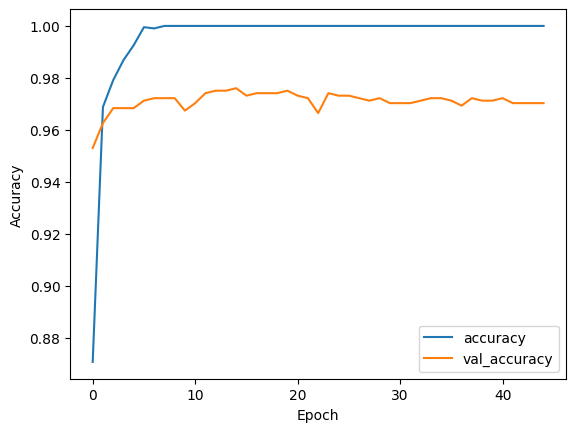

In [65]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

W0000 00:00:1722461771.722696     205 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
confusion matrix: [[ 68 166]
 [  1 389]]


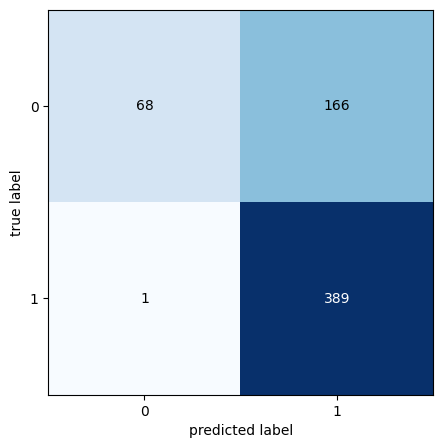

              precision    recall  f1-score   support

      Normal       0.99      0.29      0.45       234
   Pneumonia       0.70      1.00      0.82       390

    accuracy                           0.73       624
   macro avg       0.84      0.64      0.64       624
weighted avg       0.81      0.73      0.68       624

Accuracy: 0.7323717948717948
Recall: 0.6440170940170941
F1 Score: 0.6360626538844361


In [64]:
model_accuracy()

In [68]:
#lets make some fine tuning by adding more dense layer
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │    50,466,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,468,098 (192.52 MB)

 Trainable params: 50,468,098 (192.52 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
earlystop = EarlyStopping("val_accuracy", patience=30, verbose=1, restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[earlystop],
    class_weight=class_weights_dict
)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.7610 - loss: 7.0137 - val_accuracy: 0.9636 - val_loss: 0.0957
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9676 - loss: 0.0829 - val_accuracy: 0.9090 - val_loss: 0.2345
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9854 - loss: 0.0463 - val_accuracy: 0.9713 - val_loss: 0.0774
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9942 - loss: 0.0218 - val_accuracy: 0.9569 - val_loss: 0.1141
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9932 - loss: 0.0196 - val_accuracy: 0.9693 - val_loss: 0.0880
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9713 - val_loss: 0.0945
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9703 - val_loss: 0.0968
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 1.0000 - loss: 0.0014 - val_acc

In [70]:
model.evaluate(X_train,y_train)

131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 5.3568e-05


[5.225718268775381e-05, 1.0]

In [71]:
model.evaluate(X_val,y_val)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9786 - loss: 0.0906


[0.10403118282556534, 0.977011501789093]

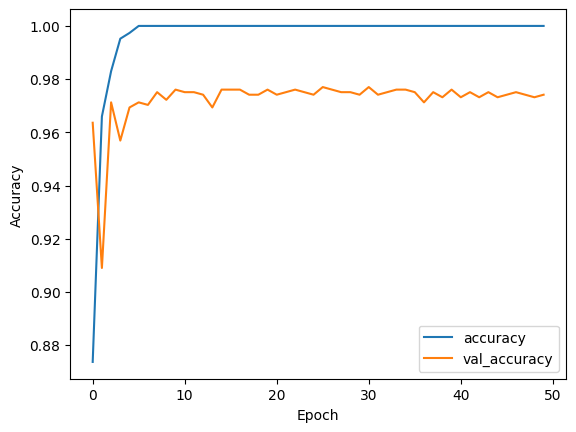

In [72]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
confusion matrix: [[ 74 160]
 [  1 389]]


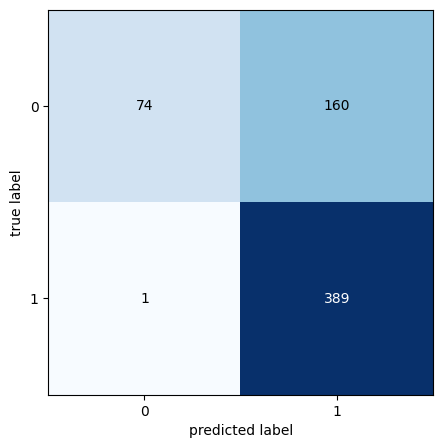

              precision    recall  f1-score   support

      Normal       0.99      0.32      0.48       234
   Pneumonia       0.71      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.66      0.65       624
weighted avg       0.81      0.74      0.70       624

Accuracy: 0.7419871794871795
Recall: 0.6568376068376068
F1 Score: 0.6537527011797306


In [73]:
model_accuracy()

In [83]:
#try using vgg19
#try using some pretrained model


vgg = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False
flat_layer = Flatten()(vgg.output)
final_layer = Dense(2, activation='softmax')(flat_layer)
model = Model(inputs=vgg.input, outputs=final_layer)
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │        50,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,074,562 (76.58 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [84]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
earlystop = EarlyStopping("val_accuracy", patience=30, verbose=1, restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[earlystop],
    class_weight=class_weights_dict
)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - accuracy: 0.8445 - loss: 0.4115 - val_accuracy: 0.9502 - val_loss: 0.1267
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.9695 - loss: 0.0734 - val_accuracy: 0.9751 - val_loss: 0.0624
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - accuracy: 0.9850 - loss: 0.0458 - val_accuracy: 0.9818 - val_loss: 0.0590
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - accuracy: 0.9904 - loss: 0.0316 - val_accuracy: 0.9559 - val_loss: 0.1053
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - accuracy: 0.9836 - loss: 0.0436 - val_accuracy: 0.9780 - val_loss: 0.0569
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.9911 - loss: 0.0241 - val_accuracy: 0.9780 - val_loss: 0.0510
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.9949 - loss: 0.0181 - val_accuracy: 0.9847 - val_loss: 0.0573
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step - accuracy: 0.9906 - loss: 0

In [85]:
model.evaluate(X_train,y_train)

131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 1.0000 - loss: 5.7105e-04


[0.0005020098760724068, 1.0]

In [86]:
model.evaluate(X_val,y_val)

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9915 - loss: 0.0278


[0.040617071092128754, 0.9875478744506836]

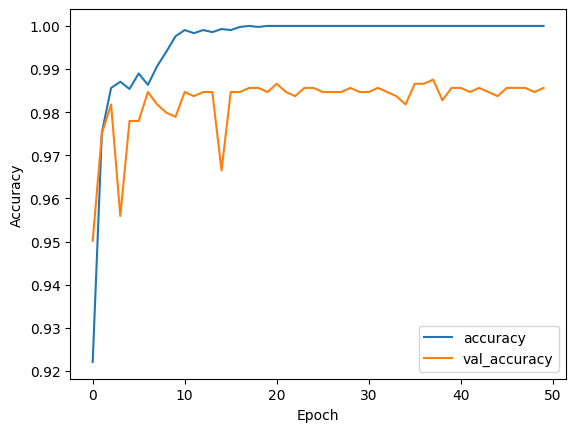

In [87]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step
confusion matrix: [[ 97 137]
 [  0 390]]


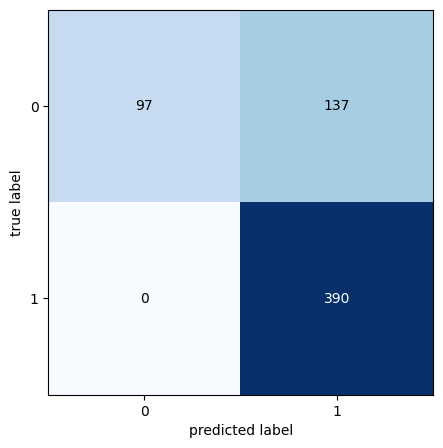

              precision    recall  f1-score   support

      Normal       1.00      0.41      0.59       234
   Pneumonia       0.74      1.00      0.85       390

    accuracy                           0.78       624
   macro avg       0.87      0.71      0.72       624
weighted avg       0.84      0.78      0.75       624

Accuracy: 0.780448717948718
Recall: 0.7072649572649573
F1 Score: 0.7183512504653622


In [88]:
model_accuracy()

In [77]:
#try using vgg16
#try using some pretrained model


vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False
flat_layer = Flatten()(vgg.output)
final_layer = Dense(2, activation='softmax')(flat_layer)
model = Model(inputs=vgg.input, outputs=final_layer)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │        50,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [78]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
earlystop = EarlyStopping("val_accuracy", patience=30, verbose=1, restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[earlystop],
    class_weight=class_weights_dict
)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 424ms/step - accuracy: 0.8695 - loss: 0.3686 - val_accuracy: 0.9741 - val_loss: 0.0683
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9730 - loss: 0.0731 - val_accuracy: 0.9751 - val_loss: 0.0743
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9808 - loss: 0.0556 - val_accuracy: 0.9741 - val_loss: 0.0556
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9899 - loss: 0.0312 - val_accuracy: 0.9866 - val_loss: 0.0389
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9933 - loss: 0.0193 - val_accuracy: 0.9761 - val_loss: 0.0567
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9928 - loss: 0.0173 - val_accuracy: 0.9875 - val_loss: 0.0361
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9973 - loss: 0.0098 - val_accuracy: 0.9866 - val_loss: 0.0372
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - accuracy: 0.9994 - loss: 0

In [79]:
model.evaluate(X_train,y_train)

131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 0.0055


[0.004372948780655861, 1.0]

In [80]:
model.evaluate(X_val,y_val)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9892 - loss: 0.0315


[0.03270931541919708, 0.99042147397995]

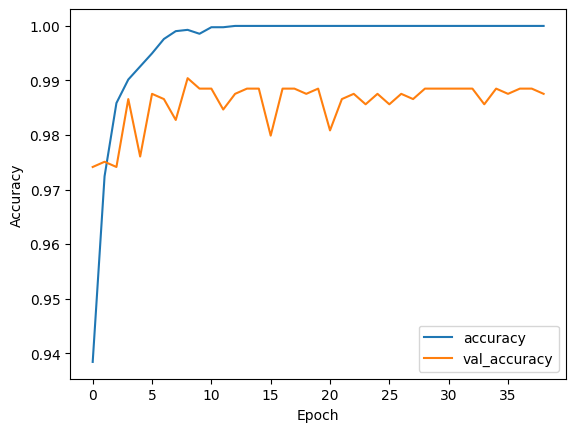

In [81]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 993ms/step
confusion matrix: [[103 131]
 [  1 389]]


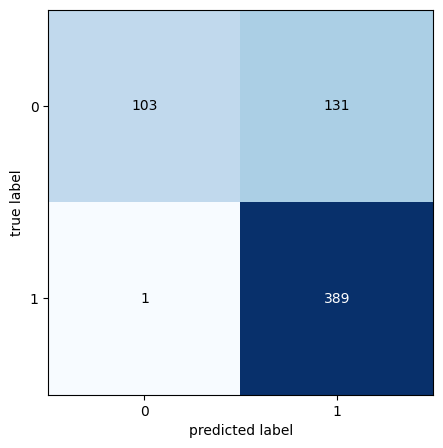

              precision    recall  f1-score   support

      Normal       0.99      0.44      0.61       234
   Pneumonia       0.75      1.00      0.85       390

    accuracy                           0.79       624
   macro avg       0.87      0.72      0.73       624
weighted avg       0.84      0.79      0.76       624

Accuracy: 0.7884615384615384
Recall: 0.7188034188034188
F1 Score: 0.7322062552831784


In [82]:
model_accuracy()

In [148]:
#loading-the-model-and-making-predictions
#function that take image and return prediction
def prediction(path):
    original_image = cv2.imread(path)       
    image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (224, 224))  
    img = np.array(resized_image)
    img= img / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    class_names = ['NORMAL', 'PNEUMONIA']
    predicted_class_index = (pred[0] > 0.5).astype(int)[0]
    predicted_class_name = class_names[predicted_class_index]  
    print(f'The predicted class for the image is: {predicted_class_name}')


In [149]:
prediction('/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0003-0001.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The predicted class for the image is: NORMAL
Raw prediction probabilities: [0.04547908 0.954521  ]


## conclusion 
# we try several model :
1. first model: simple deep learning model 
 :: Accuracy: 0.78 -  Recall: 0.72  - F1 Score: 0.73
2. second model we did some fine tuning by adding drop out layer:
::Accuracy: 0.73  -   Recall: 0.64  - F1 Score: 0.64
3. third model anther fine tuning by adding dense layer:
 ::Accuracy: 0.74 - Recall: 0.66 - F1 Score: 0.65
4. anther pretrained model vgg19
::Accuracy: 0.78  - Recall: 0.70 -F1 Score: 0.72
5. then we try pretrained model vgg16
 ::Accuracy: 0.79   -    Recall: 0.72  - F1 Score: 0.73
 # the highest accuracy and f1score is vgg16 so we use this model in reference
